In [22]:
import sys
import os
import dill
import glob
import json
import random
import argparse
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../mats")
from tqdm import tqdm, trange
from utils import prediction_output_to_trajectories
from model.model_registrar import ModelRegistrar
from model.mats import MATS
from environment.node import MultiNode
from model.dataset import EnvironmentDataset
import evaluation
import visualization
import helper as plotting_helper

from nuscenes.nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.map_expansion.map_api import NuScenesMap

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [2]:
# nuScenes_data_path = '/home/zxc/codes/MATS/experiments/nuScenes/data'  # for home
nuScenes_data_path = '/home/zxc/Downloads/nuscene'  # for 423
nusc = NuScenes(version='v1.0-trainval', dataroot=nuScenes_data_path, verbose=True)
helper = PredictHelper(nusc)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 20.7 seconds.
Reverse indexing ...
Done reverse indexing in 6.0 seconds.


In [3]:
ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', 'scene-0757')[0])

In [4]:
ns_scene

{'token': '2fc3753772e241f2ab2cd16a784cc680',
 'log_token': '3a43824b84534c98bda1d07548db5817',
 'nbr_samples': 41,
 'first_sample_token': 'cd9964f8c3d34383b16e9c2997de1ed0',
 'last_sample_token': '8fe9664cec514a58b1184c4fcefda6b5',
 'name': 'scene-0757',
 'description': 'Arrive at busy intersection, bus, wait at intersection, bicycle, peds'}

In [5]:
def load_model(model_dir, env, ts=100):
    model_registrar = ModelRegistrar(model_dir, 'cpu')
    model_registrar.load_models(ts)
    with open(os.path.join(model_dir, 'config.json'), 'r') as config_json:
        hyperparams = json.load(config_json)

    mats = MATS(model_registrar, hyperparams, None, 'cpu')
    return mats, hyperparams

In [6]:
def load_latest_model(model_dir, env):
    latest_model_path = sorted(glob.glob(os.path.join(model_dir, '*.pt')))[-1]
    latest_model_iter = int(latest_model_path.split('-')[-1].split('.')[0])
    return load_model(model_dir, env, ts=latest_model_iter)

In [7]:
def visualize_mat(mat, pred_dists, state_lengths_in_order, ax, 
                  vmin=-0.0001, center=0.00, vmax=0.0001):
    timesteps, num_samples, components = mat.shape[:3]
    
    random_dist = next(iter(pred_dists.values()))
    pis = random_dist.pis
    ml_pi_idx = torch.argmax(pis).item()
    
    line_locs = state_lengths_in_order.cumsum(1)
    
    sns.heatmap(mat[0, 0, ml_pi_idx].cpu(),
                vmin=vmin, center=center, vmax=vmax, cmap='coolwarm',
                annot=False, cbar=False, square=True,
                fmt=".2f", ax=ax)
#     ax.set_title('P(z=%d | x) = %.2f' % (ml_pi_idx, pis[ml_pi_idx]))
    ax.hlines(line_locs, *(ax.get_xlim()), colors=['white'], linewidths=3)
    ax.vlines(line_locs, *(ax.get_ylim()), colors=['white'], linewidths=3)
    ax.axis('off')

In [8]:
layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

In [10]:
with open('../processed/nuScenes_val_full.pkl', 'rb') as f:
    env = dill.load(f, encoding='latin1')

# Model Loading

In [11]:
mats, hyperparams = load_model('models/models_26_Jul_2020_17_11_34_full_zeroRrows_batch8_fixed_edges', 
                                     env, ts=16)


Loading from models/models_26_Jul_2020_17_11_34_full_zeroRrows_batch8_fixed_edges/model_registrar-16.pt
Loaded!



In [12]:
for attention_radius_override in hyperparams['override_attention_radius']:
    node_type1, node_type2, attention_radius = attention_radius_override.split(' ')
    env.attention_radius[(node_type1, node_type2)] = float(attention_radius)

if env.robot_type is None and hyperparams['incl_robot_node']:
    env.robot_type = env.NodeType[0]  # TODO: Make more general, allow the user to specify?
    for scene in env.scenes:
        scene.add_robot_from_nodes(env.robot_type,
                                   hyperparams=hyperparams,
                                   min_timesteps=hyperparams['minimum_history_length'] + 1 + hyperparams[
                                       'prediction_horizon'])

In [13]:
mats.set_environment(env)
mats.set_annealing_params()

In [14]:
scenes = env.scenes

for scene in tqdm(scenes):
    scene.calculate_scene_graph(env.attention_radius,
                                hyperparams['edge_addition_filter'],
                                hyperparams['edge_removal_filter'])

ph = hyperparams['prediction_horizon']
max_hl = hyperparams['maximum_history_length']

100%|██████████| 138/138 [00:01<00:00, 125.17it/s]


In [15]:
for idx, scene in enumerate(scenes):
    if ns_scene['first_sample_token'] in scene.sample_tokens:
        print(idx)
        break

# Plotting

In [31]:
# Good ones are: 23, 5,  
#   At timestep: 10, 54, 
scene = scenes[23] #np.random.choice(scenes)
timestep = np.array([4]) #scene.sample_timesteps(1, min_future_timesteps=ph, min_history_length=max_hl)

# print('Scene:', scenes.index(scene))
# print('Timestep:', timestep)

mats_outputs = list()
with torch.no_grad():
    mats_outputs.append(mats.predict(scene,
                                                 timestep,
                                                 ph,
                                                 min_future_timesteps=ph,
                                                 include_B=hyperparams['include_B'],
                                                 zero_R_rows=hyperparams['zero_R_rows']))
    
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=helper.get_map_name_from_sample_token(scene.name))

In [32]:
# Define ROI in nuScenes Map
pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[0]
prediction_dict, histories_dict, futures_dict = prediction_output_to_trajectories(pred_dists,
                                                                                  max_hl,
                                                                                  ph,
                                                                                  map=None)
ts_key = list(prediction_dict.keys())[0]
histories_dict = histories_dict[ts_key]
node = list(histories_dict.keys())[0]
histories_one_step = histories_dict[node][0]
x_min = scene.x_min + histories_one_step[0] - 75
y_min = scene.y_min + histories_one_step[1] - 75
x_max = scene.x_min + histories_one_step[0] + 75.0
y_max = scene.y_min + histories_one_step[1] + 75.0

In [33]:
x_min, y_min, x_max, y_max

(810.458, 1339.729, 960.458, 1489.729)

  0%|          | 0/1 [00:00<?, ?it/s]/home/zxc/miniconda3/envs/mats/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/zxc/miniconda3/envs/mats/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integer

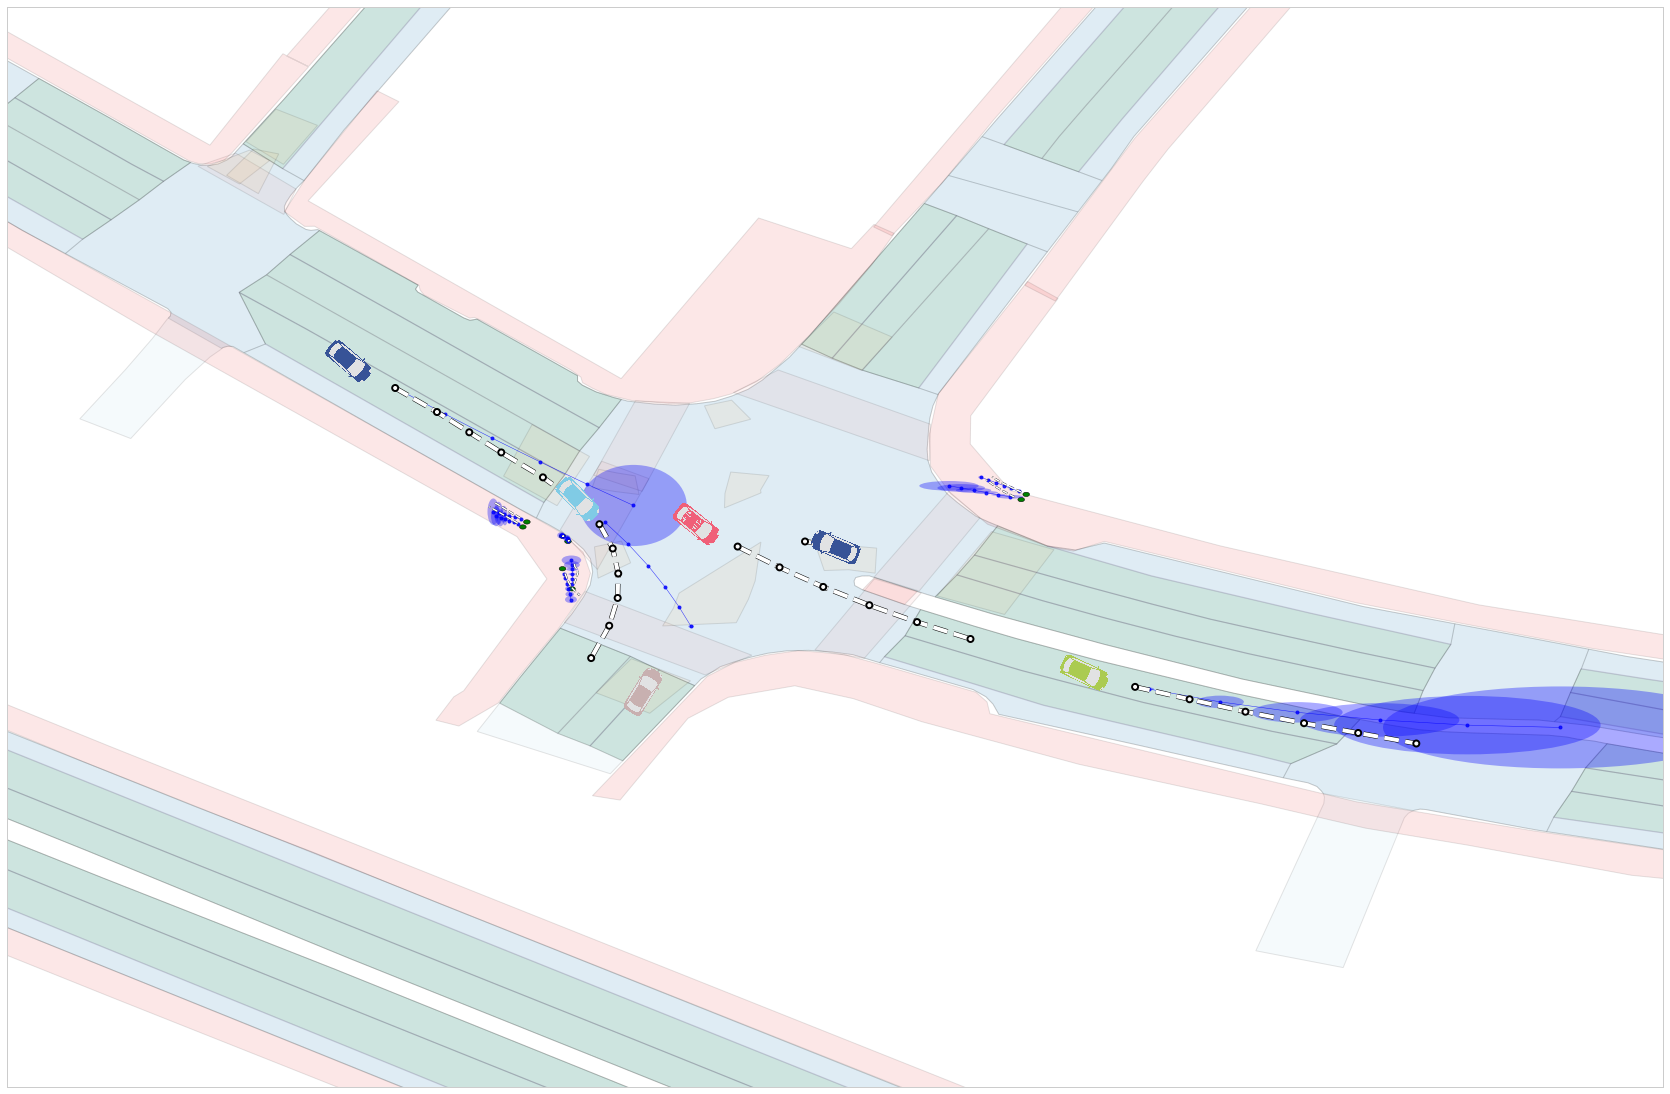

In [34]:
import matplotlib.patheffects as pe

for idx in trange(len(mats_outputs)):
    pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[idx]
    
    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(23, 15), alpha=0.1, render_egoposes_range=False)
    
    # Plot predicted timestep for random scene
#     visualization.visualize_prediction(ax,
#                                        pred_dists,
#                                        scene.dt,
#                                        max_hl=max_hl,
#                                        ph=ph,
#                                        map=None,
#                                        robot_node=scene.robot,
#                                        x_min=x_min,
#                                        y_min=y_min)
    plotting_helper.plot_vehicle_dist(ax,
                                      pred_dists,
                                      scene,
                                      max_hl=max_hl,
                                      ph=ph,
                                      x_min=scene.x_min, 
                                      y_min=scene.y_min,
                                      line_width=0.5,
                                      car_img_zoom=0.02)
    
#     ax.set_xlabel(r'x position (m)')
#     ax.set_ylabel(r'y position (m)')

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylim((y_min, y_max))
    ax.set_xlim((x_min, x_max))
    
    ax.scatter([], [], c='green', label='Pedestrian')
    ax.plot([], [], c='blue', label='Predictions')
#     ax.plot([], [], ls='--', c='k', label='History')
    ax.plot([], [], ls='--', c='w',
              path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], 
              label='Future Motion')
#     ax.legend(framealpha=1.0, frameon=True,
#               loc='center left', bbox_to_anchor=(1, 0.5))
    ax.get_legend().remove()
    ax.grid(False)
    
# fig.savefig('plots/scene_predictions_dist_2.pdf', dpi=300, bbox_inches='tight')

In [38]:
# Good ones are: 23, 5,  
#   At timestep: 10, 54, 
scene = scenes[1] #np.random.choice(scenes)
timestep = np.array([27]) #scene.sample_timesteps(1, min_future_timesteps=ph, min_history_length=max_hl)

# print('Scene:', scenes.index(scene))
# print('Timestep:', timestep)

mats_outputs = list()
with torch.no_grad():
    mats_outputs.append(mats.predict(scene,
                                                 timestep,
                                                 ph,
                                                 min_future_timesteps=ph,
                                                 include_B=hyperparams['include_B'],
                                                 zero_R_rows=hyperparams['zero_R_rows']))
    
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=helper.get_map_name_from_sample_token(scene.name))

In [39]:
# Define ROI in nuScenes Map
pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[0]
prediction_dict, histories_dict, futures_dict = prediction_output_to_trajectories(pred_dists,
                                                                                  max_hl,
                                                                                  ph,
                                                                                  map=None)
ts_key = list(prediction_dict.keys())[0]
histories_dict = histories_dict[ts_key]
node = list(histories_dict.keys())[0]
histories_one_step = histories_dict[node][0]
x_min = scene.x_min + histories_one_step[0] - 75
y_min = scene.y_min + histories_one_step[1] - 75
x_max = scene.x_min + histories_one_step[0] + 75.0
y_max = scene.y_min + histories_one_step[1] + 75.0

In [40]:
x_min, y_min, x_max, y_max

(1169.768, 582.166, 1319.768, 732.166)

  0%|          | 0/1 [00:00<?, ?it/s]/home/zxc/miniconda3/envs/mats/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/zxc/miniconda3/envs/mats/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


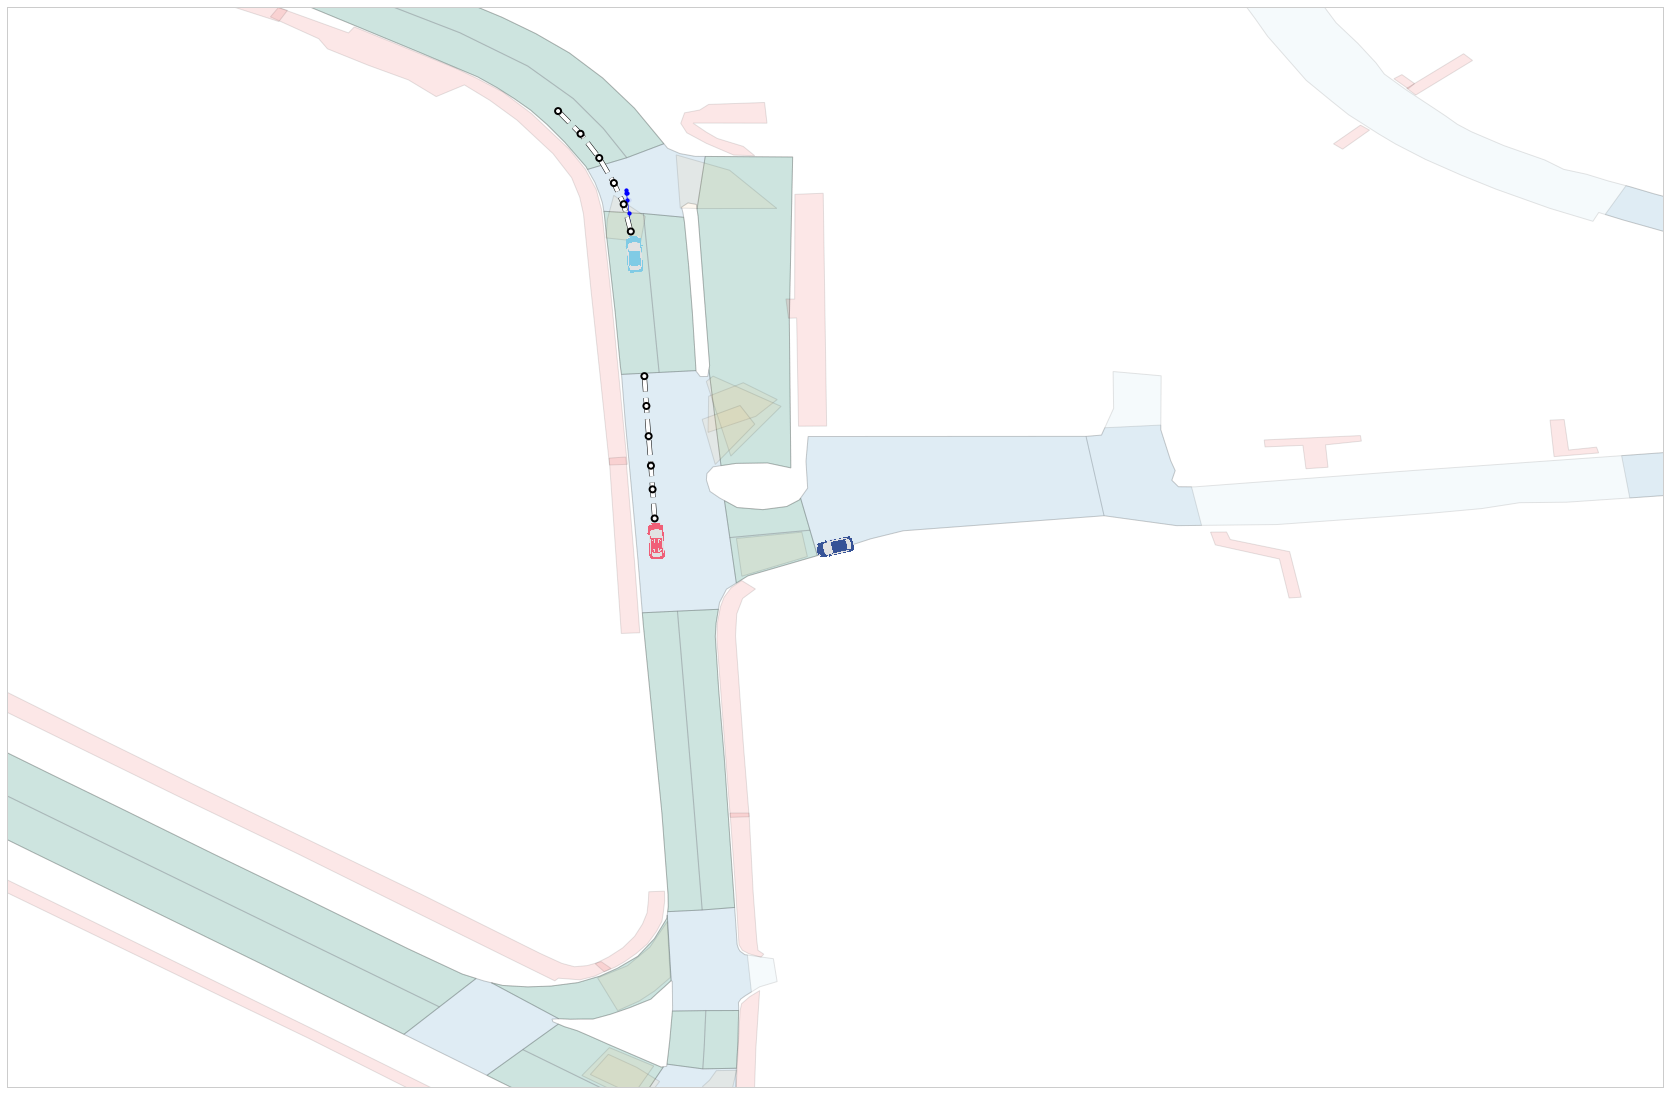

In [42]:
import matplotlib.patheffects as pe

for idx in trange(len(mats_outputs)):
    pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[idx]
    
    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(23, 15), alpha=0.1, render_egoposes_range=False)
    
    # Plot predicted timestep for random scene
#     visualization.visualize_prediction(ax,
#                                        pred_dists,
#                                        scene.dt,
#                                        max_hl=max_hl,
#                                        ph=ph,
#                                        map=None,
#                                        robot_node=scene.robot,
#                                        x_min=x_min,
#                                        y_min=y_min)
    plotting_helper.plot_vehicle_dist(ax,
                                      pred_dists,
                                      scene,
                                      max_hl=max_hl,
                                      ph=ph,
                                      x_min=scene.x_min, 
                                      y_min=scene.y_min,
                                      line_width=0.5,
                                      car_img_zoom=0.015)
    
#     ax.set_xlabel(r'x position (m)')
#     ax.set_ylabel(r'y position (m)')

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylim((y_min, y_max))
    ax.set_xlim((x_min, x_max))
    
    ax.scatter([], [], c='green', label='Pedestrian')
    ax.plot([], [], c='blue', label='Predictions')
#     ax.plot([], [], ls='--', c='k', label='History')
    ax.plot([], [], ls='--', c='w',
              path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], 
              label='Future Motion')
#     ax.legend(framealpha=1.0, frameon=True,
#               loc='center left', bbox_to_anchor=(1, 0.5))
    ax.get_legend().remove()
    ax.grid(False)
    
# fig.savefig('plots/scene_predictions_dist_3.pdf', dpi=300, bbox_inches='tight')

In [23]:
# Good ones are: 23, 5,  
#   At timestep: 10, 54, 
scene = scenes[23] #np.random.choice(scenes)
timestep = np.array([5]) #scene.sample_timesteps(1, min_future_timesteps=ph, min_history_length=max_hl)

# print('Scene:', scenes.index(scene))
# print('Timestep:', timestep)

mats_outputs = list()
with torch.no_grad():
    mats_outputs.append(mats.predict(scene,
                                                 timestep,
                                                 ph,
                                                 min_future_timesteps=ph,
                                                 include_B=hyperparams['include_B'],
                                                 zero_R_rows=hyperparams['zero_R_rows']))
    
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=helper.get_map_name_from_sample_token(scene.name))

In [24]:
# Define ROI in nuScenes Map
x_min = 773.0
x_max = 1100.0
y_min = 1231.0
y_max = 1510.0

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:12<00:00, 12.74s/it]


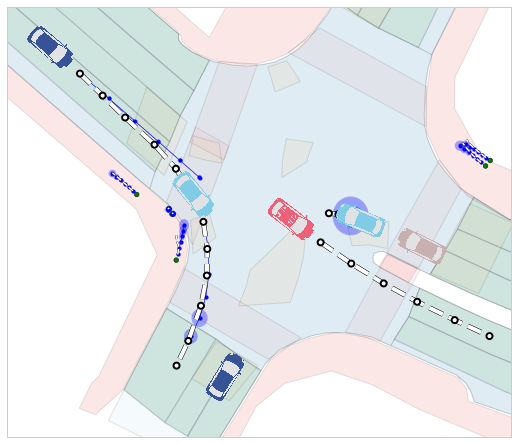

In [25]:
import matplotlib.patheffects as pe

for idx in trange(len(mats_outputs)):
    pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[idx]
    
    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(7, 7), alpha=0.1, render_egoposes_range=False)
    
    # Plot predicted timestep for random scene
#     visualization.visualize_prediction(ax,
#                                        pred_dists,
#                                        scene.dt,
#                                        max_hl=max_hl,
#                                        ph=ph,
#                                        map=None,
#                                        robot_node=scene.robot,
#                                        x_min=x_min,
#                                        y_min=y_min)
    plotting_helper.plot_vehicle_dist(ax,
                                      pred_dists,
                                      scene,
                                      max_hl=max_hl,
                                      ph=ph,
                                      x_min=scene.x_min, 
                                      y_min=scene.y_min,
                                      line_width=0.5,
                                      car_img_zoom=0.02)
    
#     ax.set_xlabel(r'x position (m)')
#     ax.set_ylabel(r'y position (m)')

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylim((1387, 1442))
    ax.set_xlim((840, 905))
    
    ax.scatter([], [], c='green', label='Pedestrian')
    ax.plot([], [], c='blue', label='Predictions')
#     ax.plot([], [], ls='--', c='k', label='History')
    ax.plot([], [], ls='--', c='w',
              path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], 
              label='Future Motion')
#     ax.legend(framealpha=1.0, frameon=True,
#               loc='center left', bbox_to_anchor=(1, 0.5))
    ax.get_legend().remove()
    ax.grid(False)
    
# fig.savefig('plots/scene_predictions_dist_1.pdf', dpi=300, bbox_inches='tight')

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:12<00:00, 12.88s/it]


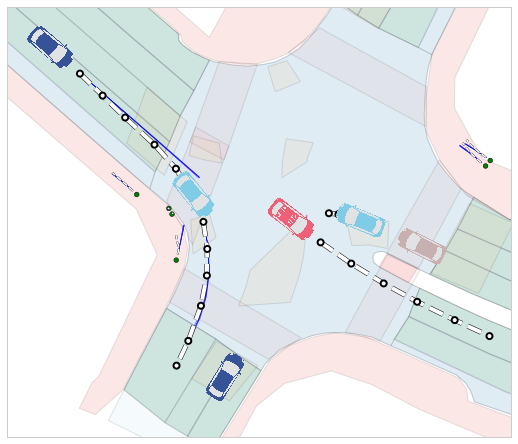

In [26]:
import matplotlib.patheffects as pe

for idx in trange(len(mats_outputs)):
    pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[idx]
    
    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(7, 7), alpha=0.1, render_egoposes_range=False)
    
    # Plot predicted timestep for random scene
#     visualization.visualize_prediction(ax,
#                                        pred_dists,
#                                        scene.dt,
#                                        max_hl=max_hl,
#                                        ph=ph,
#                                        map=None,
#                                        robot_node=scene.robot,
#                                        x_min=x_min,
#                                        y_min=y_min)
    plotting_helper.plot_vehicle_nice(ax,
                                      pred_dists,
                                      scene,
                                      max_hl=max_hl,
                                      ph=ph,
                                      x_min=x_min, 
                                      y_min=y_min,
                                      line_width=0.5,
                                      car_img_zoom=0.02)
    
#     ax.set_xlabel(r'x position (m)')
#     ax.set_ylabel(r'y position (m)')

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylim((1387, 1442))
    ax.set_xlim((840, 905))
    
    ax.scatter([], [], c='green', label='Pedestrian')
    ax.plot([], [], c='blue', label='Predictions')
#     ax.plot([], [], ls='--', c='k', label='History')
    ax.plot([], [], ls='--', c='w',
              path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], 
              label='Future Motion')
#     ax.legend(framealpha=1.0, frameon=True,
#               loc='center left', bbox_to_anchor=(1, 0.5))
    ax.get_legend().remove()
    ax.grid(False)
    
# fig.savefig('plots/scene_predictions.pdf', dpi=300, bbox_inches='tight')

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:12<00:00, 12.87s/it]


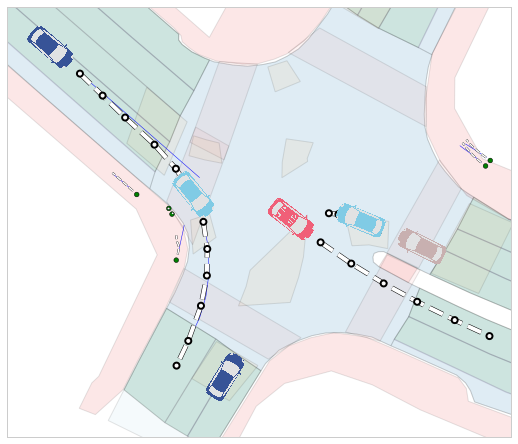

In [27]:
import matplotlib.patheffects as pe

for idx in trange(len(mats_outputs)):
    pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[idx]
    
    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(7, 7), alpha=0.1, render_egoposes_range=False)
    
    # Plot predicted timestep for random scene
#     visualization.visualize_prediction(ax,
#                                        pred_dists,
#                                        scene.dt,
#                                        max_hl=max_hl,
#                                        ph=ph,
#                                        map=None,
#                                        robot_node=scene.robot,
#                                        x_min=x_min,
#                                        y_min=y_min,
#                                        pi_alpha=True)
    plotting_helper.plot_vehicle_nice(ax,
                                      pred_dists,
                                      scene,
                                      max_hl=max_hl,
                                      ph=ph,
                                      x_min=x_min, 
                                      y_min=y_min,
                                      pi_alpha=True,
                                      line_width=0.5,
                                      car_img_zoom=0.02)
    
#     ax.set_xlabel(r'x position (m)')
#     ax.set_ylabel(r'y position (m)')

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylim((1387, 1442))
    ax.set_xlim((840, 905))
        
    ax.scatter([], [], c='green', label='Pedestrian')
    ax.plot([], [], c='blue', label='Predictions')
#     ax.plot([], [], ls='--', c='k', label='History')
    ax.plot([], [], ls='--', c='w',
              path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], 
              label='Future Motion')
#     ax.legend(framealpha=1.0, frameon=True,
#               loc='center left', bbox_to_anchor=(1, 0.5))
    ax.get_legend().remove()
    ax.grid(False)
    
# fig.savefig('plots/scene_predictions_pi_weighted.pdf', dpi=300, bbox_inches='tight')

100%|██████████| 1/1 [00:00<00:00, 252.47it/s]


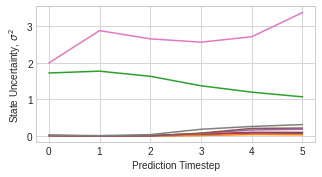

In [34]:
# Plotting uncertainty vs prediction horizon
fig, axes = plt.subplots(ncols=len(mats_outputs), 
                         figsize=(len(mats_outputs)*5, 2.5),
                         sharey=True)
for idx in trange(len(mats_outputs)):    
    pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[idx]
    
    random_dist = next(iter(pred_dists[timestep.item()].values()))
    pis = random_dist.pis
    ml_pi_idx = torch.argmax(pis).item()

    Q = Qs[0]

    for state in range(4, Q.shape[-1], 4):
        axes.plot(Q[:, 0, ml_pi_idx, state], label='x')
        axes.plot(Q[:, 0, ml_pi_idx, state+1], label='y')
        axes.plot(Q[:, 0, ml_pi_idx, state+2], label='vx')
        axes.plot(Q[:, 0, ml_pi_idx, state+3], label='vy')
    
#     axes.legend(loc='best');
    axes.set_xlabel('Prediction Timestep');
    axes.set_ylabel(r'State Uncertainty, $\sigma^2$');
    
# fig.savefig('plots/Q_entries_vs_time.pdf', dpi=300, bbox_inches='tight')

100%|██████████| 3/3 [00:00<00:00, 21.82it/s]


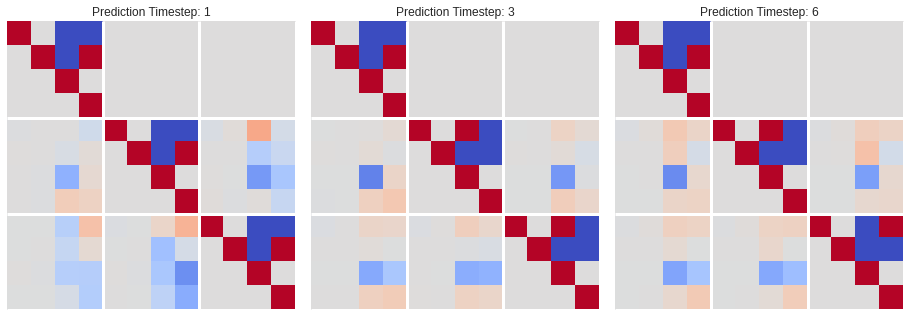

In [35]:
# Plot most-likely A matrices across time.
ph = hyperparams['prediction_horizon']
fig, axes = plt.subplots(ncols=3, 
                         figsize=(3*4.2, 4))

for idx in range(len(mats_outputs)):
    pred_dists, _, As, _, _, _, state_lengths_in_order = mats_outputs[idx]
    for i, ts in enumerate(tqdm([0, 2, 5])):
        visualize_mat(As[0][[ts]], pred_dists[timestep.item()], state_lengths_in_order, axes[i])
        
        title_str = axes[i].get_title()
        axes[i].set_title(f"Prediction Timestep: {ts+1}");
#         axes[i].set_title([f'$A$ Matrix Before Interaction, $t_{{pred}} = {{{ts+1}}}$',
#                            f'$A$ Matrix During Interaction, $t_{{pred}} = {{{ts+1}}}$',
#                            f'$A$ Matrix After Interaction, $t_{{pred}} = {{{ts+1}}}$'][i])
        
fig.tight_layout(pad=-0.5)
# fig.savefig(f'plots/ml_A_mats_vs_time.pdf', dpi=300, bbox_inches='tight')

# Graph Stuff

In [30]:
with open('../processed/nuScenes_val_full_doubled.pkl', 'rb') as f:
    env = dill.load(f, encoding='latin1')

In [31]:
mats, hyperparams = load_model('models/models_21_Jul_2020_10_25_10_full_zeroRrows_batch8_double_fixed_a_norm', 
                                     env, ts=11)


Loading from models/models_21_Jul_2020_10_25_10_full_zeroRrows_batch8_double_fixed_a_norm/model_registrar-11.pt
Loaded!



In [32]:
for attention_radius_override in hyperparams['override_attention_radius']:
    node_type1, node_type2, attention_radius = attention_radius_override.split(' ')
    env.attention_radius[(node_type1, node_type2)] = float(attention_radius)

if env.robot_type is None and hyperparams['incl_robot_node']:
    env.robot_type = env.NodeType[0]  # TODO: Make more general, allow the user to specify?
    for scene in env.scenes:
        scene.add_robot_from_nodes(env.robot_type,
                                   hyperparams=hyperparams,
                                   min_timesteps=hyperparams['minimum_history_length'] + 1 + hyperparams[
                                       'prediction_horizon'])

In [33]:
mats.set_environment(env)
mats.set_annealing_params()

In [34]:
scenes = env.scenes

for scene in tqdm(scenes):
    scene.calculate_scene_graph(env.attention_radius,
                                hyperparams['edge_addition_filter'],
                                hyperparams['edge_removal_filter'])

ph = hyperparams['prediction_horizon']
max_hl = hyperparams['maximum_history_length']

100%|██████████| 138/138 [00:02<00:00, 56.88it/s]


In [35]:
# Good ones are: 
# All at timestep: 16
scene = scenes[23] #np.random.choice(scenes)
timestep = np.array([6]) #scene.sample_timesteps(1, min_future_timesteps=ph, min_history_length=max_hl)

# print('Scene:', scenes.index(scene))
# print('Timestep:', timestep)

mats_outputs = list()
with torch.no_grad():
    mats_outputs.append(mats.predict(scene,
                                                 timestep,
                                                 ph,
                                                 min_future_timesteps=ph,
                                                 include_B=hyperparams['include_B'],
                                                 zero_R_rows=hyperparams['zero_R_rows']))
    
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=helper.get_map_name_from_sample_token(scene.name))

In [36]:
from utils import calculate_A_slices

for idx in range(len(mats_outputs)):
    pred_dists, _, As, _, _, _, state_lengths_in_order = mats_outputs[idx]
    
    random_dist = next(iter(pred_dists[timestep.item()].values()))
    pis = random_dist.pis
    ml_pi_idx = torch.argmax(pis).item()
    
    A = As[0]
    summed_state_lengths_in_order = torch.zeros((state_lengths_in_order.shape[0], state_lengths_in_order.shape[1] + 1),
                                                dtype=state_lengths_in_order.dtype)
    summed_state_lengths_in_order[:, 1:] = torch.cumsum(state_lengths_in_order, dim=1)
    
    ordered_nodes = [scene.robot] + list(pred_dists[timestep.item()].keys())
    relation_magnitudes = np.zeros((A.shape[0], len(ordered_nodes), len(ordered_nodes)))
    for ts in trange(A.shape[0]):
        for orig_idx, orig_node in enumerate(ordered_nodes):
            for dest_idx, dest_node in enumerate(ordered_nodes):
                if orig_idx == dest_idx:
                    continue

                rows, cols = calculate_A_slices(orig_idx, dest_idx, 
                                                state_lengths_in_order[0], 
                                                summed_state_lengths_in_order[0])

                relation_magnitudes[ts, dest_idx, orig_idx] = np.linalg.norm(A[ts, 0, ml_pi_idx, rows, cols])

100%|██████████| 12/12 [00:00<00:00, 157.72it/s]


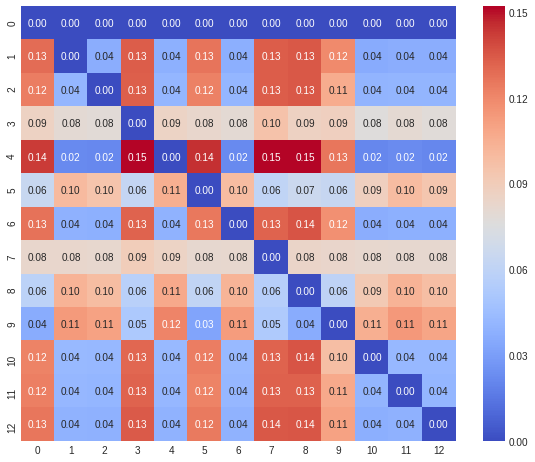

In [37]:
normed_magnitudes = relation_magnitudes / (relation_magnitudes.sum(axis=2, keepdims=True) + 1e-6)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(normed_magnitudes[0], cmap='coolwarm',
            annot=True, cbar=True, square=True,
            fmt=".2f", ax=ax);

In [38]:
# Define ROI in nuScenes Map
x_min = 773.0
x_max = 1100.0
y_min = 1231.0
y_max = 1510.0

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:11<00:00, 11.38s/it]


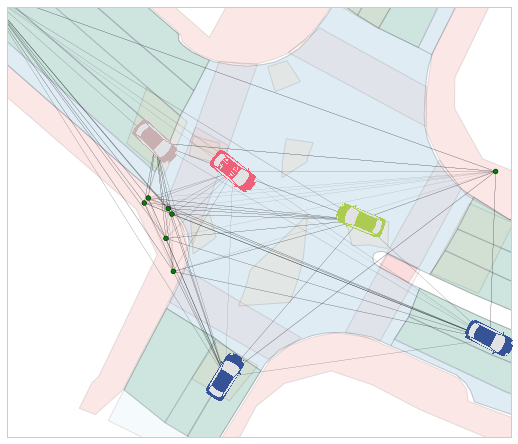

In [39]:
import matplotlib.patheffects as pe

for idx in trange(len(mats_outputs)):
    pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[idx]
    
    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(7, 7), alpha=0.1, render_egoposes_range=False)
    
    # Plot predicted timestep for random scene
#     visualization.visualize_prediction(ax,
#                                        pred_dists,
#                                        scene.dt,
#                                        max_hl=max_hl,
#                                        ph=ph,
#                                        map=None,
#                                        robot_node=scene.robot,
#                                        x_min=x_min,
#                                        y_min=y_min,
#                                        pi_alpha=True)
    plotting_helper.plot_vehicle_nice(ax,
                                      pred_dists,
                                      scene,
                                      max_hl=max_hl,
                                      ph=ph,
                                      x_min=x_min, 
                                      y_min=y_min,
                                      pi_alpha=True,
                                      line_width=0.5,
                                      car_img_zoom=0.02,
                                      plot_future=False,
                                      plot_prediction=False)
    
    position_state = {'position': ['x', 'y']}
    for orig_idx, orig_node in enumerate(ordered_nodes):
        for dest_idx, dest_node in enumerate(ordered_nodes):
            if orig_idx == dest_idx:
                continue

            curr_orig = orig_node.get(np.array([timestep.item()]), position_state) + np.array([x_min, y_min])
            curr_dest = dest_node.get(np.array([timestep.item()]), position_state) + np.array([x_min, y_min])

            ax.plot([curr_orig[0, 0], curr_dest[0, 0]], 
                    [curr_orig[0, 1], curr_dest[0, 1]],
                    c='k', linewidth=normed_magnitudes[0, dest_idx, orig_idx])
    
#     ax.set_xlabel(r'x position (m)')
#     ax.set_ylabel(r'y position (m)')

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylim((1387, 1442))
    ax.set_xlim((840, 905))
        
    ax.scatter([], [], c='green', label='Pedestrian')
    ax.plot([], [], c='blue', label='Predictions')
#     ax.plot([], [], ls='--', c='k', label='History')
    ax.plot([], [], ls='--', c='w',
              path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], 
              label='Future Motion')
#     ax.legend(framealpha=1.0, frameon=True,
#               loc='center left', bbox_to_anchor=(1, 0.5))
    ax.get_legend().remove()
    ax.grid(False)
    
# fig.savefig('plots/scene_predictions_pi_weighted_A_graph.pdf', dpi=300, bbox_inches='tight')

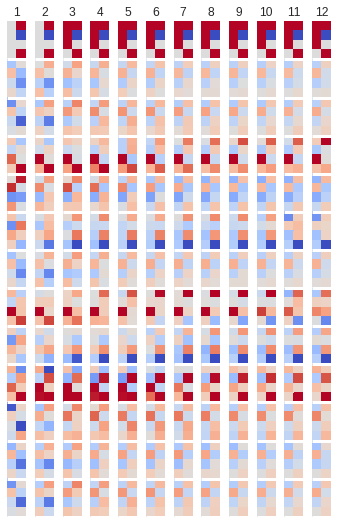

In [40]:
# Plot most-likely B matrices across time.
ph = hyperparams['prediction_horizon']
fig, axes = plt.subplots(nrows=len(mats_outputs), ncols=ph, 
                         figsize=(ph*0.4, len(mats_outputs)*8))
for idx in range(len(mats_outputs)):
    pred_dists, _, _, Bs, _, _, state_lengths_in_order = mats_outputs[idx]
    for ts in range(ph):
        visualize_mat(Bs[0][[ts]], pred_dists[timestep.item()], state_lengths_in_order, axes[ts],
                      vmin=-0.005, vmax=0.005)
        axes[ts].set_title(f'{ts + 1}')
        
fig.tight_layout()
# fig.savefig(f'plots/ml_B_mats_vs_time.pdf', dpi=300, bbox_inches='tight')

In [41]:
from utils import calculate_BQ_slices

for idx in range(len(mats_outputs)):
    pred_dists, _, _, Bs, _, _, state_lengths_in_order = mats_outputs[idx]
    
    random_dist = next(iter(pred_dists[timestep.item()].values()))
    pis = random_dist.pis
    ml_pi_idx = torch.argmax(pis).item()
    
    B = Bs[0]
    summed_state_lengths_in_order = torch.zeros((state_lengths_in_order.shape[0], state_lengths_in_order.shape[1] + 1),
                                                dtype=state_lengths_in_order.dtype)
    summed_state_lengths_in_order[:, 1:] = torch.cumsum(state_lengths_in_order, dim=1)
    
    ordered_nodes = [scene.robot] + list(pred_dists[timestep.item()].keys())
    relation_magnitudes = np.zeros((B.shape[0], len(ordered_nodes)))
    for ts in trange(B.shape[0]):
        for dest_idx, dest_node in enumerate(ordered_nodes):
            if dest_idx == 0:
                continue

            rows = calculate_BQ_slices(dest_idx, 
                                       state_lengths_in_order[0], 
                                       summed_state_lengths_in_order[0])

            relation_magnitudes[ts, dest_idx] = np.linalg.norm(B[ts, 0, ml_pi_idx, rows])

100%|██████████| 12/12 [00:00<00:00, 2090.18it/s]


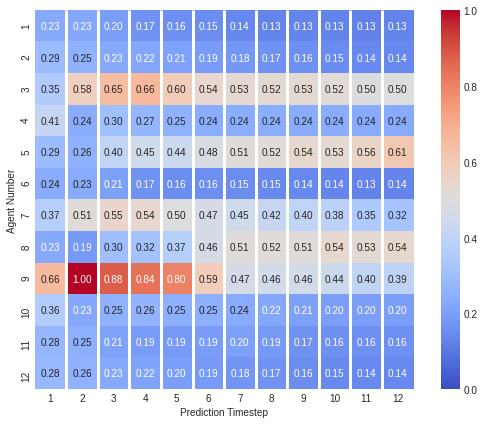

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))

normed_magnitudes = relation_magnitudes[:, 1:] / relation_magnitudes.max()

line_locs = range(1, ph)

sns.heatmap(normed_magnitudes.T, cmap='coolwarm',
            vmin=0.0, vmax=1.0,
            annot=True, cbar=True, square=True,
            fmt=".2f", ax=ax, 
            xticklabels=range(1, ph+1),
            yticklabels=range(1, len(ordered_nodes)));

ax.vlines(line_locs, *(ax.get_ylim()), colors=['white'], linewidths=3)

ax.set_xlabel('Prediction Timestep');
ax.set_ylabel('Agent Number');

fig.tight_layout()
# fig.savefig(f'plots/ml_B_mags_vs_time.pdf', dpi=300, bbox_inches='tight')

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:11<00:00, 11.30s/it]


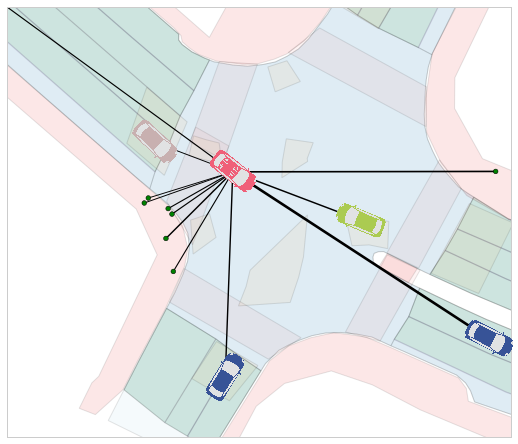

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:11<00:00, 11.33s/it]


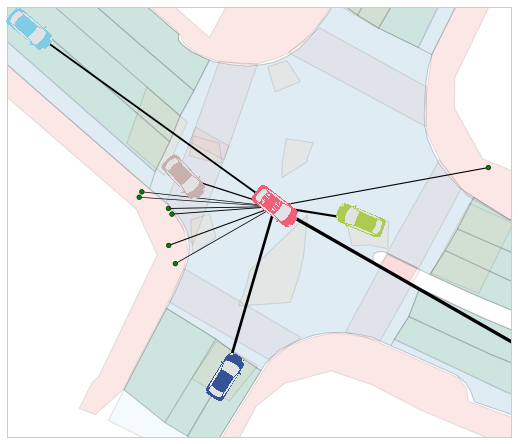

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:11<00:00, 11.28s/it]


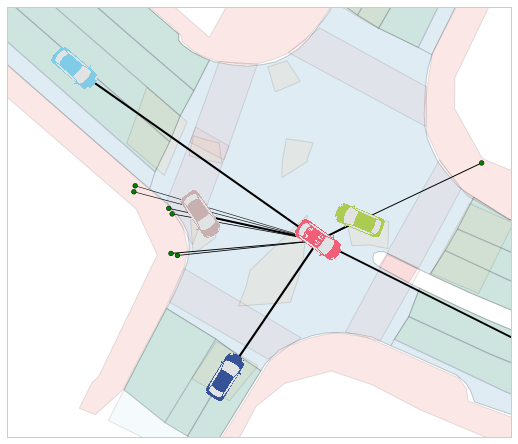

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:11<00:00, 11.15s/it]


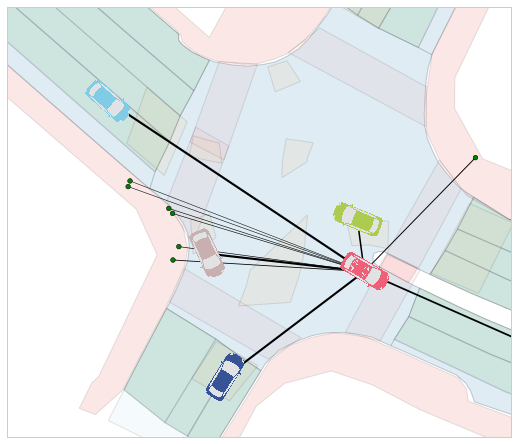

In [43]:
import matplotlib.patheffects as pe

# 0 is the normal setting, all vehicles are at their current timesteps.
# Values > 0 fast-forward time (but from the perspective of the current timestep, so it's like what the future is
# believed to be from the current timestep, hence why we use this timestep's predicted information to see what the
# ego-vehicle's influence will be in the future).
at_timesteps = [0, 3, 6, 9]
for at_timestep in at_timesteps:
    
    for idx in trange(len(mats_outputs)):
        pred_dists, non_rob_rows, As, Bs, Qs, affine_terms, state_lengths_in_order = mats_outputs[idx]

        # Plot predicted timestep for random scene in map
        my_patch = (x_min, y_min, x_max, y_max)
        fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(7, 7), alpha=0.1, render_egoposes_range=False)

        # Plot predicted timestep for random scene
    #     visualization.visualize_prediction(ax,
    #                                        pred_dists,
    #                                        scene.dt,
    #                                        max_hl=max_hl,
    #                                        ph=ph,
    #                                        map=None,
    #                                        robot_node=scene.robot,
    #                                        x_min=x_min,
    #                                        y_min=y_min,
    #                                        pi_alpha=True)
        plotting_helper.plot_vehicle_nice(ax,
                                          pred_dists,
                                          scene,
                                          max_hl=max_hl,
                                          ph=ph + 5,
                                          x_min=x_min, 
                                          y_min=y_min,
                                          pi_alpha=True,
                                          line_width=0.5,
                                          car_img_zoom=0.02,
                                          plot_future=False,
                                          plot_prediction=False,
                                          at_timestep=at_timestep)

        position_state = {'position': ['x', 'y']}
        curr_orig = scene.robot.get(np.array([timestep.item() + at_timestep]), position_state) + np.array([x_min, y_min])
        for dest_idx, dest_node in enumerate(ordered_nodes):
            if 0 == dest_idx:
                continue

            curr_dest = dest_node.get(np.array([timestep.item() + at_timestep]), position_state) + np.array([x_min, y_min])
            ax.plot([curr_orig[0, 0], curr_dest[0, 0]], 
                    [curr_orig[0, 1], curr_dest[0, 1]],
                    c='k', 
                    linewidth=4*normed_magnitudes[at_timestep, dest_idx-1])

#         ax.set_xlabel(r'x position (m)')
#         ax.set_ylabel(r'y position (m)')

        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_ylim((1387, 1442))
        ax.set_xlim((840, 905))

        ax.scatter([], [], c='green', label='Pedestrian')
        ax.plot([], [], c='blue', label='Predictions')
    #     ax.plot([], [], ls='--', c='k', label='History')
        ax.plot([], [], ls='--', c='w',
                  path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], 
                  label='Future Motion')
#         ax.legend(framealpha=1.0, frameon=True,
#                   loc='center left', bbox_to_anchor=(1, 0.5))
        ax.get_legend().remove()
        ax.grid(False)

#     fig.savefig(f'plots/scene_predictions_pi_weighted_B_graph_t{at_timestep}.pdf', dpi=300, bbox_inches='tight')
    plt.show()